In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class Potts_model2D ():
    def __init__ (self,L,q,alinged=False):
        self.L = L
        self.q = q
        self.q_set = np.arange(self.q+1,dtype=np.int32)[1:]
        self.alinged = alinged
        self.shp = (self.L,self.L)
        self.spin_config_init()


    def spin_config_init(self):
        if self.alinged==False:
            self.spin_config = np.random.choice(self.q_set,size=self.shp)

        if self.alinged==True:
            self.spin_config = np.ones(shape=self.shp,dtype=np.int32)


    def magnetization(self):
        '''
        seek for spins which equal to 1
        '''
        magnetization = 0
        for i in Lattice.spin_config.reshape(L*L): # create a view of lattice only (shallow-copy)
            if i==1:
                magnetization +=1
        return magnetization
        #return np.sum(self.spin_config) # ???????????????


    def pbc (self,idx):
        if idx == self.L-1:
            return 0
        else:
            return idx+1


    def energy_site(self,spin,i,j):
        sum_of_neighbours = 0
        for neighbour in [self.spin_config[i-1,j], self.spin_config[self.pbc(i),j], self.spin_config[i,j-1], self.spin_config[i,self.pbc(j)]]:
            if spin == neighbour:
                sum_of_neighbours +=1

        #print('sum potts (how many same) = ',sum_of_neighbours) # for debug
        return -sum_of_neighbours



    def energy_total(self):
        result = 0
        for i in range(self.L):
            for j in range(self.L):
                spin = self.spin_config[i,j]
                result += self.energy_site(spin,i,j) # -ve sign due to -J (ferromagnetic) in the hamitonian

        return result/2 # correct for overcounting due to overlapping


    def update (self,T):
        """determine if a spin is updated according to metropolis monte-carlo rules, under a specified temperature T. """
        for i in range(self.L):
            for j in range(self.L):
                spin = self.spin_config[i,j]
                proposed_spin = self.q_set[self.q_set!=self.spin_config[i,j]][np.random.randint(self.q-1)]
                #proposed_spin = np.random.choice(self.q_set[self.q_set!=self.spin_config[i,j]])
                denergy = self.energy_site(proposed_spin,i,j)-self.energy_site(spin,i,j)
                if denergy<0:
                    self.spin_config[i,j] = proposed_spin
                else:
                    if np.e**(-denergy/T)>np.random.uniform(0,1):
                        self.spin_config[i,j] = proposed_spin
                #print('spin is:',self.spin_config[i,j],' set is: ',self.q_set[self.q_set!=self.spin_config[i,j]],' selected: ',selected_state) #for debug


    def batch_flip (self,N_run,N_ss,T):
        """
        the main calculation routine to calculate the values
        
        parameters
        N_run: total number of complete monte-carlo steps (sweep through the lattice)
        N_ss: total number of complete MCS before sampling starts
        T: temperature
        """
        M=0
        m=0
        M_sq=0
        E=0
        e=0
        E_sq=0

        ### stepping only lattice; no data sampling #####
        for k in range (N_ss):
            self.update(T)

        count = 0
        for k in range (N_ss,N_run):
            self.update(T)
            m= self.magnetization()
            M+=m
            M_sq+=m**2
            e=self.energy_total()
            E+=e
            E_sq+=e**2

            #fname = '{:.2f}i{}.npy'.format(round(T,2),count)
            #np.save(fname,self.lattice)
            count += 1
        
        volume = self.L**2
        M_mean=M/(N_run-N_ss)
        M_var=M_sq/(N_run-N_ss)-M_mean**2
        E_mean=E/(N_run-N_ss)
        E_var=E_sq/(N_run-N_ss)-E_mean**2
        C=E_var/T**2/volume
        Chi=M_var/T/volume

        return T, M_mean/volume , E_mean/volume ,C , Chi # temporary take out lattice, which is global 





## set your parameters here ##############
L=40
q=2
N_run=1000;     ###=100 for trouble shooting; 2000 for production run
fracN_ss=0.4   ### = 0.5 default. Must be a fractional number >=0 && < 1.
DeltaT=0.1     ###=1.0 for trouble shooting; 0.05 for production run
Tini=0.000;Tlast=5.0;  #default: Tini=0.0; Tlast=5.0
## end of set your parameters here ##############

### initialization ####
Lattice = Potts_model2D(L,q,alinged=True)
N_ss = int(fracN_ss*N_run);   ### step at which sampling of data begins
T_range = np.arange(Tini,Tlast+DeltaT,DeltaT)
sample_size = (N_run-N_ss)*T_range.shape[0]
ctn = np.zeros((T_range.shape[0],5),dtype=np.float32)
#######################

### begin calculation ##########
print(20*'=',' Sampling in progress ','='*20)

batch = 0
for T in T_range:
    print("T =",T)
    ctn[batch][0],ctn[batch][1],ctn[batch][2],ctn[batch][3],ctn[batch][4]=Lattice.batch_flip(N_run,N_ss,T)
    batch +=1

print(20*'=',' end of Sampling ','='*20)
print('\n')


np.savetxt('pottsq2.txt',ctn)

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def visualization(target):
    with open(target,'r') as file:
        line = file.readline()
        file.close()
    print(line)


    rawdata=np.loadtxt(target,skiprows=0)
    datahs=np.hsplit(rawdata,5)
    temperature=datahs[0];M_avg=datahs[1];E_avg=datahs[2];C=datahs[3];Chi=datahs[4];

    fig=plt.figure(figsize=(20,15))
    fig.suptitle('2D Potts Model via Metropolis Monte-Carlo Simulation', fontsize=20)

    ax0=plt.subplot(2,2,1)
    ax0.plot(temperature,M_avg,'-o')
    ax0.set_title('Magnetization with temperature',fontsize=16)
    ax0.set_ylabel('$<M>$ (normalized,per spin)',fontsize=14)
    ax0.set_xlabel('Temperature',fontsize=14)

    ax1=plt.subplot(2,2,2)
    ax1.plot(temperature,E_avg,'-o')
    ax1.set_title('Energy with temperature',fontsize=16)
    ax1.set_ylabel('$<E>$(normalized,per spin)',fontsize=14)
    ax1.set_xlabel('Temperature',fontsize=14)

    ax2=plt.subplot(2,2,3)
    ax2.plot(temperature,C,'-o')
    ax2.set_title('Heat Capacity with Temperature',fontsize=16)
    ax2.set_ylabel('$C$ (normalized,per spin)',fontsize=14)
    ax2.set_xlabel('Temperature',fontsize=14)

    ax3=plt.subplot(2,2,4)
    ax3.plot(temperature,Chi,'-o')
    ax3.set_title('Subceptibility with Temperature',fontsize=16)
    ax3.set_ylabel('$\chi$ (normalized,per spin)',fontsize=14)
    ax3.set_xlabel('Temperature',fontsize=14)

    plt.show()

# L=40 q=3 N_run=2000 fracN_ss =0.5 ; T M E C Chi



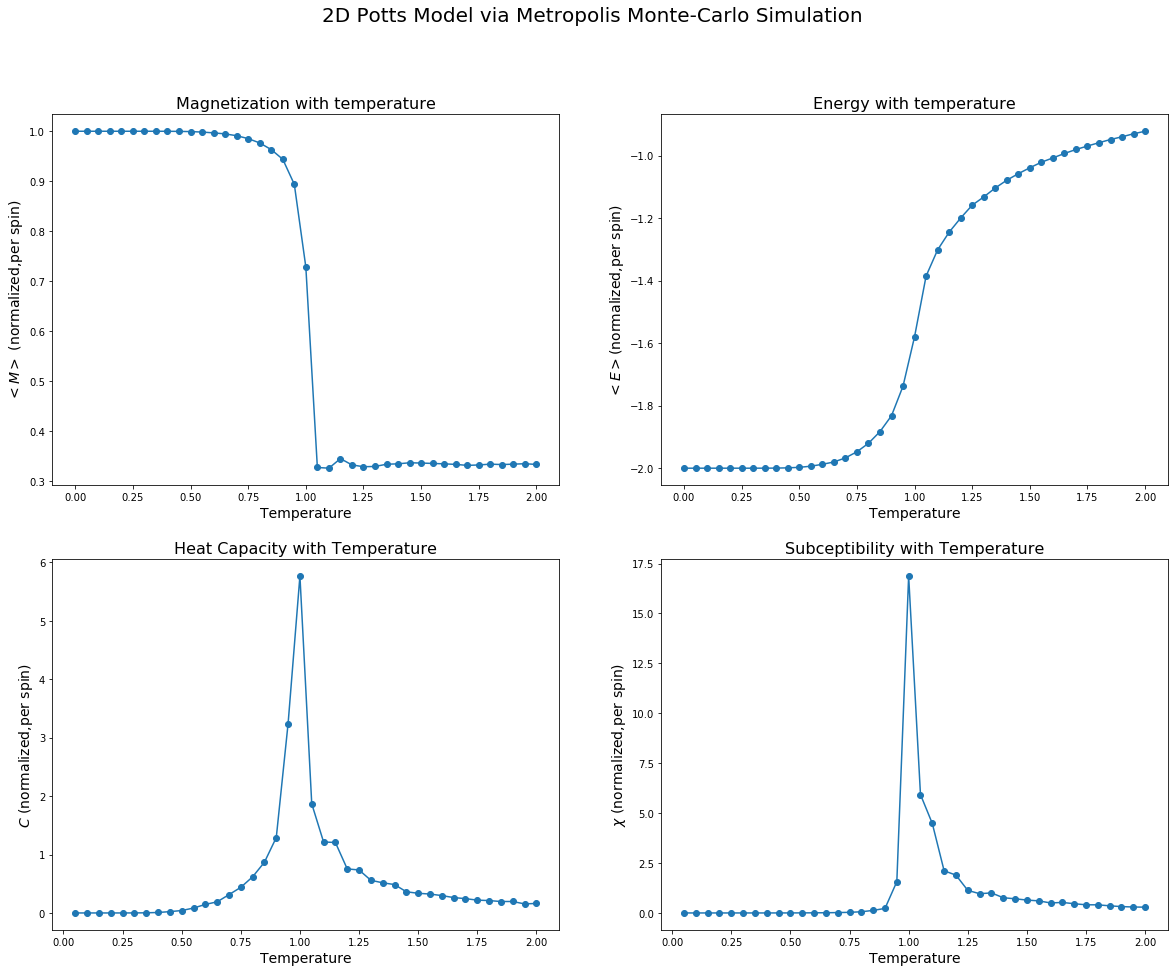

In [5]:
visualization("/home/junkai/potts/data20200918q_3/run_gen_data.txt")